In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# MNIST

In [2]:
# fetch dataset from OpenML.org
mnist = fetch_openml("mnist_784", as_frame=False)

In [3]:
X, y = mnist.data, mnist.target

In [4]:
# display an image
def plot_image(img):
    image = img.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

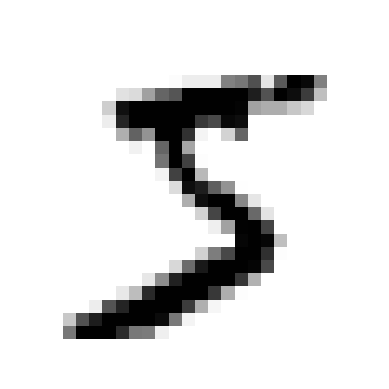

In [5]:
# peek first digit
some_digit = X[0]
plot_image(some_digit)

In [6]:
# check it's label
y[0]

'5'

In [7]:
# split dataset before inspecting the data closely
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5

In [8]:
# create the target vectors for this classification task
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
# stochastic gradient descent 
from sklearn.linear_model import SGDClassifier

In [10]:
sgd_clf = SGDClassifier(random_state=42)

# train
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [11]:
# predict
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures
many performance measures available
### Measuring Accuracy Using Cross-Validation

>cross-validation means splitting the training set into k folds\
then training the model k times, holding out a different fold each time for evaluation

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 95% accuracy (ratio of correct predictions) on all cross-validation folds

>dummy classifier that classifies every single image in the most frequent class, which in this case is the negative class

In [14]:
from sklearn.dummy import DummyClassifier

In [15]:
dummy_clf = DummyClassifier(random_state=42)
dummy_clf.fit(X_train, y_train_5)

,strategy,'prior'
,random_state,42
,constant,None


In [16]:
any(dummy_clf.predict(X_train)) # prints False: no 5s detected

False

In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

- over 90% accuracy 
- because only about 10% of the images are 5s
- so if image is not a 5, right about 90% of the time

>This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets\
(i.e. when some classes are much more frequent than others)

### Confusion Matrices

In [18]:
from sklearn.model_selection import cross_val_predict

In [19]:
# train and predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [22]:
# exemple of perfect classifier 
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision
accuracy of the positive predictions\
well predicted positives (True Positive) divided by all the positives predicted (True Positive + False Positive)
>$precision = \dfrac{TP}{(TP+FP)}$

In [23]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred) # 3530 / (3530 + 687)

0.8370879772350012

### Recall
also called sensitivity or the true positive rate (TPR)
>$recall = \dfrac{TP}{(TP+FN)}$

In [25]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred) # 3530 / (3530 + 1891)

0.6511713705958311

### F1 score
F1 score is the harmonic mean of precision and recall
>$F1 score = 2 * (\dfrac{precision * recall}{precision + recall})$

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

### The Precision/Recall Trade-off
raise the threshold increase the precision\
lowering the threshold increases recall (it reduces precision)

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

threshold equal to 0 has the same result as the predict() method

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

raising the threshold decreases recall

In [29]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

To decide which threshold to use :\
use the cross_val_predict() function to get the scores of all instances in the training set\
and return decision scores instead of predictions

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function\
to compute precision and recall for all possible thresholds 

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

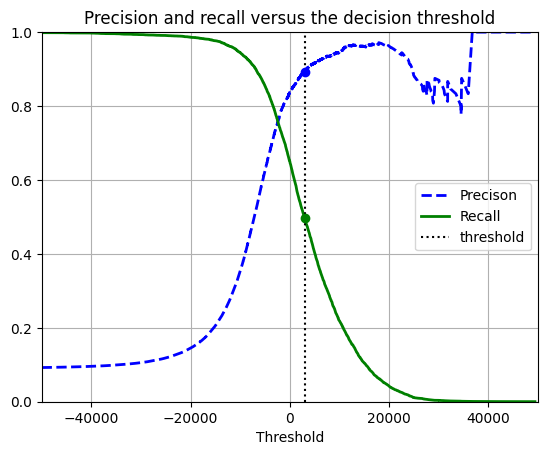

In [32]:
#  plot precision and recall 
plt.plot(thresholds, precisions[:-1], "b--", label="Precison", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1., "k", "dotted", label="threshold")

# this just beautifies plot
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.title("Precision and recall versus the decision threshold")

plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall

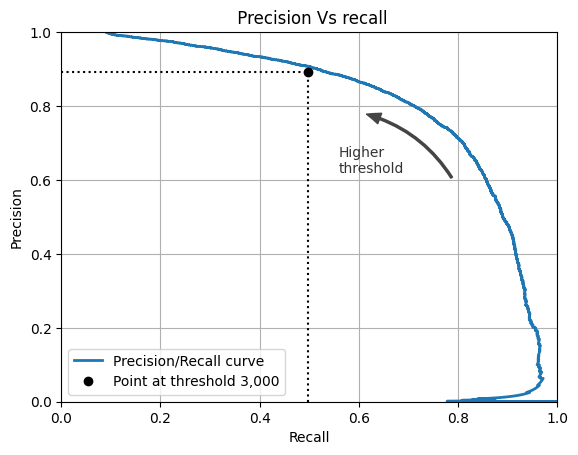

In [33]:
import matplotlib.patches as patches

plt.plot(precisions, recalls, linewidth=2, label="Precision/Recall curve")

# beautifies plot
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.title(" Precision Vs recall")

plt.show()

To search for the lowest threshold that gives at least 90% precision \
use the NumPy array’s argmax() method \
returns the first index of the maximum value

In [34]:
idx_for_90_precision = (precisions > .9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.019499144183

In [35]:
# To make predictions with .9 precison instead of calling the classifier’s predict() method 
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve
>TPR Vs FPR

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers\
TPR A.K.A Recall A.K.A Sensitivity\
FPR A.K.A 1 – specificity\
TNR A.K.A Specificity


In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

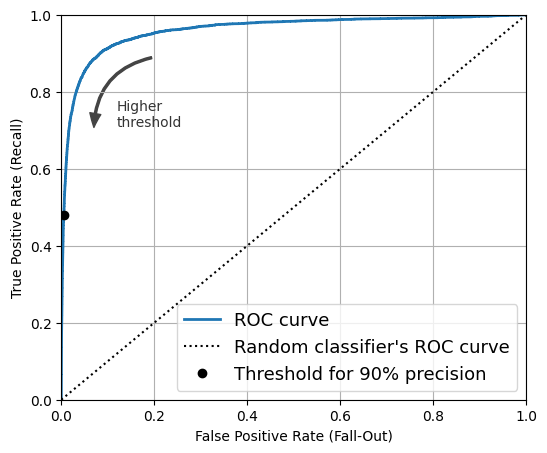

In [39]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

# formatting
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

One way to compare classifiers is to measure the area under the curve (AUC)

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [41]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42) 

In [42]:
# compute proba to compare with SGDClassifier
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [43]:
y_probas_forest[:3]

array([[0.11, 0.89],
       [0.98, 0.02],
       [0.96, 0.04]])

predict true, false, false ....

In [44]:
y_scores_forest = y_probas_forest[:, 1]

In [45]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

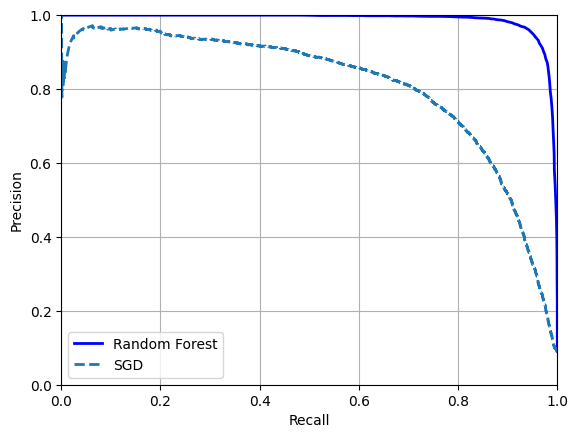

In [46]:
plt.Figure(figsize=(6, 5))
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Comparing PR curves: the random forest classifier is superior to the SGD classifier because its PR curve is much closer to the top-right corner, and it has a greater AUC

In [47]:
y_train_pred_forest = y_probas_forest[:, 1] >= .5

In [48]:
f1_score(y_train_5, y_train_pred_forest)

0.9270445185330457

In [49]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

In [50]:
precision_score(y_train_5, y_train_pred_forest)

0.9895331798199707

In [51]:
recall_score(y_train_5, y_train_pred_forest)

0.8719793396052389

## Multiclass Classification

- Whereas binary classifiers distinguish between two classes
- multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes

In [52]:
from sklearn.svm import SVC

In [53]:
svm_clf = SVC(random_state=42)

# OvO strategy and trained 45 binary classifiers
svm_clf.fit(X_train[:2000], y_train[:2000])

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [54]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and it’s indeed the one corresponding to class 5

In [56]:
class_id = some_digit_scores.argmax()
class_id

5

In [57]:
# class label of classifier
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [58]:
svm_clf.classes_[class_id]

'5'

example of multiclass classifier using the OvR strategy

In [59]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,estimator,SVC(random_state=42)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


In [60]:
# prediction
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [61]:
len(ovr_clf.estimators_)

10

In [62]:
# SGDClassifier on a multiclass dataset
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [63]:
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [64]:
sgd_clf.decision_function([some_digit]).round(2)

array([[-31893.03, -34419.69,  -9530.64,   1823.73, -22320.15,  -1385.8 ,
        -26188.91, -16147.51,  -4604.35, -12050.77]])

In [65]:
# evaluate the model
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

- Over 85.8% on all test folds
- Simply scaling the inputs increases accuracy 

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

In [67]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay

In [69]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

###  colored diagram of the confusion matrix

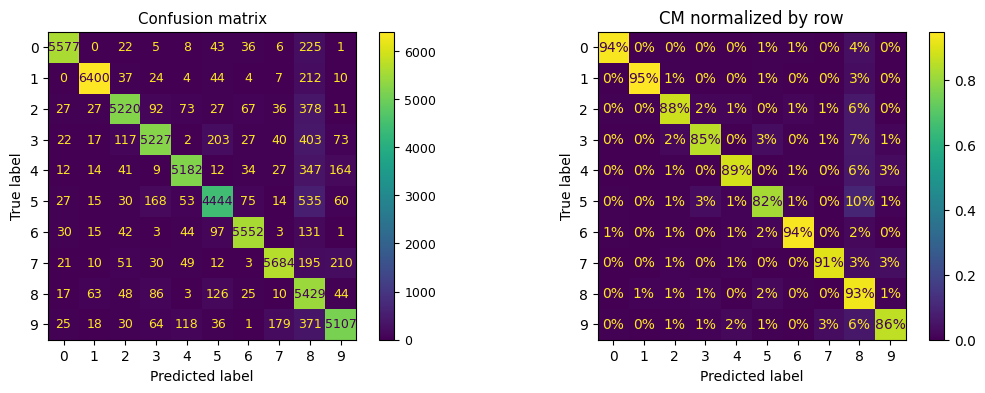

In [70]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

plt.rc('font', size=9)
axs[0].set_title("Confusion matrix")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])

plt.rc('font', size=10)
axs[1].set_title("CM normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%", ax=axs[1])
plt.show()

###  Confusion matrix with errors only, normalized by row (left) and by column (right)

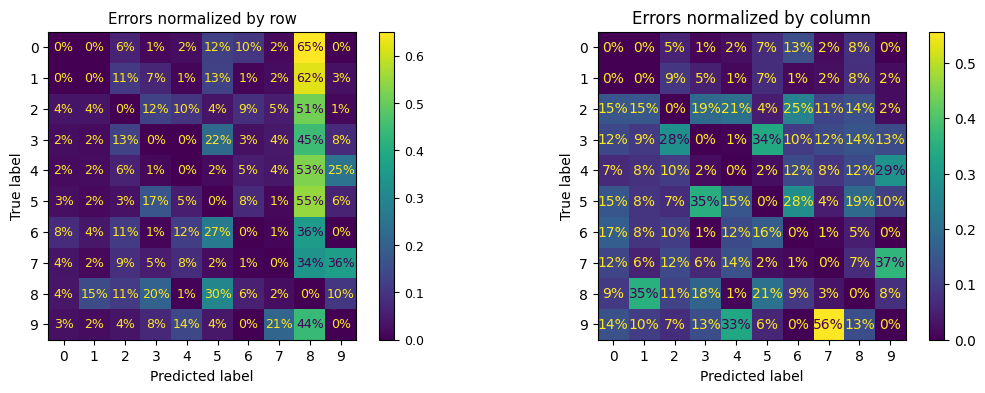

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sample_weight = (y_train_pred != y_train)

plt.rc('font', size=9)
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,  ax=axs[0], sample_weight=sample_weight, normalize="true", values_format=".0%")

plt.rc('font', size=10)
axs[1].set_title("Errors normalized by column")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1], sample_weight=sample_weight, normalize="pred", values_format=".0%")
plt.show()

many images got misclassified as 8s

## Multilabel Classification

-  classifier that outputs multiple classes for each instance 

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
# whether or not the digit is large (7, 8, or 9)
y_train_large = (y_train >= '7')

In [74]:
# whether or not it is odd
y_train_odd = (y_train.astype("int8") % 2 == 1)

In [75]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [76]:
# supports multilabel classification 
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [77]:
knn_clf.predict([some_digit])

array([[False,  True]])

The digit 5 is indeed not large (False) and odd (True)

In [78]:
#  measure the F1 score for each individual label
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [79]:
# compute the average score
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

This approach assumes that all labels are equally important, which may not be the case.\
One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label).\
To do this, set average="weighted" when calling the f1_score() function. 

In [80]:
# ChainClassifier
from sklearn.multioutput import ClassifierChain

In [81]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

,estimator,SVC()
,order,None
,cv,3
,chain_method,'predict'
,random_state,42
,verbose,False
,base_estimator,'deprecated'
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [82]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification

- generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values)

This exemple of system that removes noise from images :
- take as input a noisy digit image
- output a clean digit image, represented as an array of pixel intensities

In [83]:
np.random.seed(42)  # to make example reproducible

In [84]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

In [85]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [86]:
y_train_mod = X_train
y_test_mod = X_test

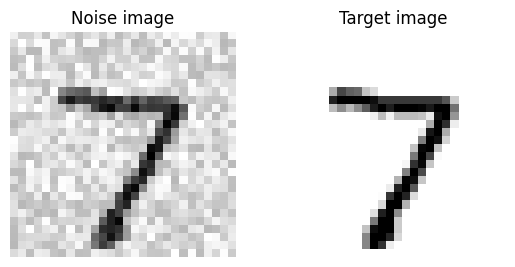

In [87]:
# peek first image of test set
plt.subplot(121)
plot_image(X_test_mod[0])
plt.title("Noise image")

plt.subplot(122)
plot_image(y_test_mod[0])
plt.title("Target image")

plt.show()

In [88]:
# train the classifier to clean noise from image
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [89]:
clean_digit = knn_clf.predict([X_test_mod[0]])

Text(0.5, 1.0, 'Clean image')

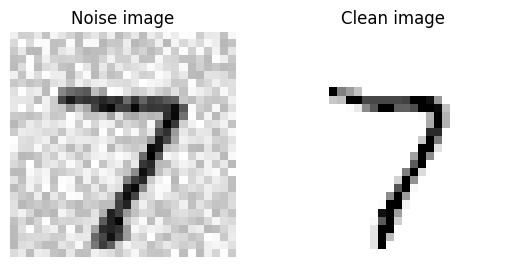

In [90]:
plt.subplot(121)
plot_image(X_test_mod[0])
plt.title("Noise image")

plt.subplot(122)
plot_image(clean_digit)
plt.title("Clean image")